# LSTM

In [0]:
# data wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# language model 
import spacy
spacy_en = spacy.load('en')

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils import data

from collections import Counter
import copy
import re
import matplotlib.pyplot as plt
import matplotlib 

In [0]:
torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Text processing

In [0]:
def tokenizer(text): 
    text = text.lower()
    text = re.sub("-rrb-","", text)
    text = re.sub("-lrb-","", text)
    tokens = spacy_en.tokenizer(text)
    #tokens = [tok for tok in tokens if tok.is_stop == False]
    tokens = [tok.lemma_ for tok in tokens]
    return tokens

In [0]:
class Vocabulary:
      
    def __init__(self, vocabCount, min_freq):
        # initialize PAD and UNK tokens
        self.PAD_token = 0   
        self.UNK_token = 1
        self.vocabCount = vocabCount
        self.min_freq = min_freq
        # initialize list of words and vocab dictionary
        self.wordlist = ["<pad>", "<unk>"]
        self.word2index = {}

        self.build_vocab(self.vocabCount)

    def __len__(self):
        return len(self.word2index)

    def __getitem__(self, word):
        return self.word2index.get(word, 1)

    def __iter__(self):
        return iter(vocab.word2index)

    def build_vocab(self, vocabCount):
        for word in self.vocabCount:
            if vocabCount[word] >= self.min_freq:
                self.wordlist.append(word)
        self.word2index.update({tok: i for i, tok in enumerate(self.wordlist)})

## Load and process data

In [0]:
train_data = pd.read_csv('../data/train.tsv', sep="\t", encoding="utf_8_sig")
phrases = np.array(train_data.iloc[:, 2])
target = np.array(train_data.iloc[:, 3])

# create train and validation sets
X_train , X_val, y_train , y_val = train_test_split(phrases, target, 
                                                    test_size = 0.2, random_state=42)

# create validation and test sets
X_val , X_test, y_val , y_test = train_test_split(X_val, y_val, 
                                                    test_size = 0.4, random_state=42)

In [9]:
X_train = [tokenizer(phrase) for phrase in X_train]
X_val = [tokenizer(phrase) for phrase in X_val]
X_test = [tokenizer(phrase) for phrase in X_test]

print("Length of train dataset: {} \nLength of validation dataset: {} \nLength of test dataset: {}".format(len(X_train), len(X_val), len(X_test)))

Length of train dataset: 124848 
Length of validation dataset: 18727 
Length of test dataset: 12485


## Create vocabularly

In [0]:
vocabCount = Counter([item for sublist in X_train for item in sublist])
vocab = Vocabulary(vocabCount, 1)

In [0]:
X_trainNum = [torch.tensor([vocab[word] for word in phrase]) for phrase in X_train]
X_valNum = [torch.tensor([vocab[word] for word in phrase]) for phrase in X_val]
X_testNum = [torch.tensor([vocab[word] for word in phrase]) for phrase in X_test]

In [12]:
# make sure each tensor actually has values
for i, el in enumerate(X_trainNum):
    if el.nelement() == 0:
        print(i)
        X_trainNum[i] = torch.tensor([0]).long()

43785


In [0]:
# make sure each tensor actually has values
for i, el in enumerate(X_valNum):
    if el.nelement() == 0:
        print(i)
        X_valNum[i] = torch.tensor([0]).long()

In [14]:
# make sure each tensor actually has values
for i, el in enumerate(X_testNum):
    if el.nelement() == 0:
        print(i)
        X_testNum[i] = torch.tensor([0]).long()

7117


## Dataset class and batching function

In [0]:
class WordDataset(data.Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):  
        X = self.X[idx]
        Y = self.y[idx]
        return X, Y

In [0]:
def generate_batch(batch):
    
    # get inputs and targets
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # to be able to pack sequences later on, need
    # the original sequence lengths
    seqlengths = [len(el) for el in data]
    
    # pad the sequences
    x = pad_sequence(data, batch_first=True)

    return x, torch.Tensor(targets), seqlengths

In [0]:
trainingset = WordDataset(X_trainNum, y_train)
valset = WordDataset(X_valNum, y_val)
testset = WordDataset(X_testNum, y_test)

In [0]:
training_generator = data.DataLoader(trainingset, batch_size=64, collate_fn=generate_batch)
val_generator = data.DataLoader(valset, batch_size=len(y_val), collate_fn=generate_batch)
test_generator = data.DataLoader(testset, batch_size=len(y_test), collate_fn=generate_batch)

In [0]:
training_eval = data.DataLoader(trainingset, batch_size=512, collate_fn = generate_batch)

## Training loop and evaluation function

In [0]:
def train(m, lossFun, optim, scheduler, epochs, train_loader, val_loader, train_eval,
          saveModel = False, verbose=False):

    print("Summary of model\n")
    print(m)
    print("\n")

    # initialize lists to store loss and accuracy
    trainLossVec , valLossVec, trainAccuracyVec, valAccuracyVec = [], [], [], []
    bestLoss, bestEpoch = 100, 0

    # get number of batches
    numberBatches = len(train_loader)

    for epoch in range(epochs):

        # Set model to training mode
        m.train()
    
        # Loop over each batch from the training set
        for batch_idx, (inputs, targets, seqlengths) in enumerate(train_loader):
            
            # Zero gradient buffers
            optim.zero_grad()
            # Foward pass and compute loss on batch
            outputs = m(inputs.to(device), seqlengths)
            batchloss = lossFun(outputs, targets.long().to(device))
            # Backpropagate and update weights
            batchloss.backward()
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(m.parameters(), 1., norm_type=2)
            # optimizer step
            optim.step()
    
        # set model to evaluation mode
        m.eval()
        with torch.no_grad():
            
            # evaluate model on training and validation data
            acc, loss = evalModel(m, {"train": train_eval, "val": val_loader}, lossFun)
            # update accuracy
            trainAccuracyVec.append(acc["train"])
            valAccuracyVec.append(acc["val"])
            # update loss
            trainLossVec.append(loss["train"])
            valLossVec.append(loss["val"])
            
            scheduler.step()
    
            # check if new best for validation accuracy
            if valLossVec[-1] < bestLoss:
                bestLoss = valLossVec[-1]
                bestEpoch = epoch
                if saveModel == True:
                    torch.save(m.state_dict(), "bestModel.pt")
                    print("New best value for validation loss: Saved model to bestModel.pt")
            
            # print information about training progress
            if verbose == True:
                print(("Epoch: {} \t Loss (train): {:.3f} (val): {:.3f} \t" +
              "Acc (train) {:.3f} (val): {:.3f}").format(epoch + 1,
                            trainLossVec[-1], valLossVec[-1], trainAccuracyVec[-1], valAccuracyVec[-1]))
            # clean up
            del inputs, targets, outputs, acc, loss

    return trainLossVec, valLossVec, trainAccuracyVec, valAccuracyVec, bestEpoch

In [0]:
def evalModel(model, dataDict, lossFun):
    
    keys = list(dataDict.keys())
    values = [0] * len(keys)

    acc = dict(zip(keys, values))
    lossDict = dict(zip(keys, values))

    model.eval()
    with torch.no_grad():
        
        for data in dataDict.keys():

            lossVal = 0
            correct = 0

            for (inputs, targets, seqlengths) in dataDict[data]:
                
                batchsize = len(targets)
                outputs = model(inputs.to(device), seqlengths)
                lossVal += lossFun(outputs, targets.long().to(device)).item() * batchsize

                _, pred = torch.max(outputs.data, 1)
                correct += (pred == targets.long().to(device)).sum().item()
                
            lossVal = lossVal/len(dataDict[data].dataset)
            accuracy = correct/len(dataDict[data].dataset)

            acc[data] = accuracy * 100
            lossDict[data] = lossVal

            del inputs, targets, outputs

    return acc, lossDict

## Download word embeddings

In [22]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-01-29 19:42:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-29 19:42:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-29 19:42:31--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [36]:
print('Indexing word vectors.')
embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found {} word vectors.'.format(len(embeddings_index)))

Indexing word vectors.
Found 400000 word vectors.


In [37]:
# iterate through each word in the vocabularly
# if there exists a word embedding insert it,
# else use a sample from a random normal
matrix_len = len(vocab)
weights_matrix = np.zeros((matrix_len, 300))
words_notfound = 0

for i, word in enumerate(vocab):
    try: 
        weights_matrix[i] = embeddings_index[word]
        # if there is no embedding for the given word
        # create vector sampled from random normal

        # a advantage of updating the weights of the
        # embedding layer as part of training, is that
        # an embedding will be learnt for these words 
    except KeyError:

        weights_matrix[i] = np.random.normal(scale=0.5, size=(300, ))
        words_notfound += 1

# clean up
del embeddings_index

print("Words not found: {}".format(words_notfound))

Words not found: 442


## Model

In [0]:
class LSTM(nn.Module):
    
    def __init__(self, embeddingDIM, hiddenDIM1, hiddenDIM2, outputDIM, 
                 n_layers, vocab_size):
    
        super(LSTM, self).__init__()    

        self.embedding = nn.Embedding(vocab_size, embeddingDIM, padding_idx=0)
        self.lstm = nn.LSTM(embeddingDIM, hiddenDIM1, num_layers = n_layers, batch_first = True)
        self.linear1 = nn.Linear(hiddenDIM1, hiddenDIM2)
        self.linear2 = nn.Linear(hiddenDIM2, outputDIM)
        self.dropout = nn.Dropout()

    def forward(self, inputs, seqlengths):

        # input size: (batchsize, longest_seq)
        
        # get embeddings for each sequence
        embeds = self.embedding(inputs.long()).to(device)
        # size after embedding: (batchsize, longest_seq, embed_dim)
    
        # as sequences are padded, pack them
        inputs = pack_padded_sequence(embeds, seqlengths, 
                  enforce_sorted=False, batch_first=True)
        # size after packing: (sum(seqlengths), embed_dim)
    
        # as we leave the second argument empty, the hidden states are
        # initialized to zero - and also reset after every batch
        packed_output, (hidden, cell) = self.lstm(inputs)
        # packed output size: (sum(seqlengths), hidden_dim)
        # hidden size: (n_layers, batchsize, hidden_dim)
    
        # need hidden state from last layer
        lastState = hidden[-1]
    
        # linear layer
        output = self.dropout(F.relu(self.linear1(lastState)))
        output = self.linear2(output)
    
        return output

In [0]:
torch.manual_seed(42)
model = LSTM(300, 300, 100, 5, 1, len(vocab)).to(device) 
model.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
model.embedding.weight.requires_grad = False
optimizer = optim.Adam(model.parameters(), lr = 6e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) 
loss = nn.CrossEntropyLoss()

In [56]:
trainLossVec, valLossVec, trainAccuracyVec, valAccuracyVec, bestEpoch = train(model, loss, optimizer, 
                  scheduler, 15, training_generator, val_generator, training_eval, verbose = True)

Summary of model

LSTM(
  (embedding): Embedding(12135, 300, padding_idx=0)
  (lstm): LSTM(300, 300, batch_first=True)
  (linear1): Linear(in_features=300, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch: 1 	 Loss (train): 0.882 (val): 0.901 	Acc (train) 62.789 (val): 62.258
Epoch: 2 	 Loss (train): 0.807 (val): 0.852 	Acc (train) 65.994 (val): 64.431
Epoch: 3 	 Loss (train): 0.742 (val): 0.823 	Acc (train) 68.606 (val): 65.932
Epoch: 4 	 Loss (train): 0.703 (val): 0.815 	Acc (train) 70.230 (val): 66.951
Epoch: 5 	 Loss (train): 0.688 (val): 0.813 	Acc (train) 70.861 (val): 67.101
Epoch: 6 	 Loss (train): 0.676 (val): 0.811 	Acc (train) 71.407 (val): 67.197
Epoch: 7 	 Loss (train): 0.672 (val): 0.807 	Acc (train) 71.654 (val): 67.320
Epoch: 8 	 Loss (train): 0.670 (val): 0.806 	Acc (train) 71.723 (val): 67.299
Epoch: 9 	 Loss (train): 0.669 (val): 0.806 	Acc (train) 71.802 (val): 67.304
Ep

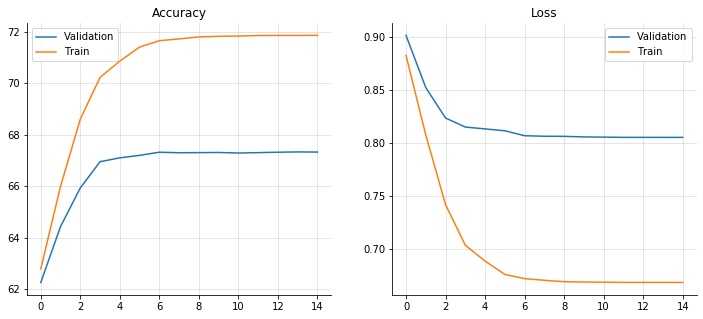

In [57]:
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(range(len(valAccuracyVec)), valAccuracyVec, label = "Validation")
ax1.plot(range(len(trainAccuracyVec)), trainAccuracyVec, label = "Train")
ax1.grid(True, alpha=0.4)
ax1.set_title("Accuracy")
ax1.legend()
ax2.plot(range(len(valLossVec)), valLossVec, label = "Validation")
ax2.plot(range(len(trainLossVec)), trainLossVec, label = "Train")
ax2.grid(True, alpha=0.4)
ax2.set_title("Loss")
ax2.legend()
plt.show()

## Fine-tuning word embeddings

In [0]:
torch.manual_seed(42)
model = LSTM(300, 300, 100, 5, 1, len(vocab)).to(device) 
model.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
optimizer = optim.Adam([
                {'params': [model.lstm.weight_ih_l0,
    model.lstm.weight_hh_l0, model.lstm.bias_ih_l0,
    model.lstm.bias_hh_l0, model.linear1.weight,
    model.linear1.bias, model.linear2.weight,
    model.linear2.bias], 'lr': 6e-4},
                {'params': model.embedding.weight, 'lr': 5e-6}
            ])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) 
loss = nn.CrossEntropyLoss()

In [99]:
trainLossVec, valLossVec, trainAccuracyVec, valAccuracyVec, bestEpoch = train(model, loss, optimizer, 
                  scheduler, 15, training_generator, val_generator, training_eval, verbose = True)

Summary of model

LSTM(
  (embedding): Embedding(12135, 300, padding_idx=0)
  (lstm): LSTM(300, 300, batch_first=True)
  (linear1): Linear(in_features=300, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch: 1 	 Loss (train): 0.878 (val): 0.897 	Acc (train) 63.052 (val): 62.680
Epoch: 2 	 Loss (train): 0.803 (val): 0.848 	Acc (train) 66.180 (val): 64.623
Epoch: 3 	 Loss (train): 0.735 (val): 0.817 	Acc (train) 68.942 (val): 66.140
Epoch: 4 	 Loss (train): 0.699 (val): 0.812 	Acc (train) 70.423 (val): 66.807
Epoch: 5 	 Loss (train): 0.685 (val): 0.811 	Acc (train) 71.074 (val): 67.010
Epoch: 6 	 Loss (train): 0.672 (val): 0.811 	Acc (train) 71.585 (val): 67.128
Epoch: 7 	 Loss (train): 0.667 (val): 0.805 	Acc (train) 71.884 (val): 67.411
Epoch: 8 	 Loss (train): 0.666 (val): 0.805 	Acc (train) 71.972 (val): 67.469
Epoch: 9 	 Loss (train): 0.664 (val): 0.805 	Acc (train) 72.040 (val): 67.437
Ep